In [1]:
import pandas as pd
df = pd.read_csv('../scribe_text_analysis.csv')
df.head()

,Case 1: Adam dont have any questions to discuss,"Case 2: Adam writes questions he has, in the email reply itself",Case 3: Adam is busy and will revert back to megan later (without a specific time),Case 4: Adam is busy and will get in touch with Megan after few days/weeks with mentioned time in email,Case 5: Adam wants to discuss over a call and might or might not provide time
0,"I don't have any questions at this time, but I...",I do have a few questions. Do you have any ot...,"I'm currently tied up on a project, but I'll e...","I'm currently tied up on a project , but I'll ...",I'd be interested in speaking on the phone. C...
1,"Hi Megan,\nThank you for taking the time to fo...","Hi Megan ,\nThank you for taking the time to f...","Hi Megan,\n Thank you for writing to me in reg...","Hi Megan,\nThank you for taking the time to fo...","Hi Megan,\n Thank you for writing to let you ..."
2,"Hi Megan, \nI don't have any questions at the ...","Hi Megan, \nI am having problems opening the e...","Hi Megan, \nI am busy at the moment but I will...","Hi Megan, \nI am busy at the moment but I will...","Hi Megan, \nI would like to talk on the phone ..."
3,"Thank you, right now I have any further questi...",Do you have any questions for me?,"Hello Megan,\nI'm sorry, I am currently busy a...",Hello Megan I am currently busy at the moment ...,"Hello, I would like to be able to set up a tim..."
4,"Hi Megan,\n\nAt this time, I no longer have an...","Hi Megan,\n\nI was wondering if you could tell...","Hi Megan, \n\nI am currently really busy and u...","Hi Megan,\n\nI am extrmely busy at the moment,...","Hi Megan,\n\nI do actually have some questions..."


In [2]:
data_dict = {'category': [], 'text': []}
for no_question_text in df['Case 1: Adam dont have any questions to discuss']:
    data_dict['category'].append('No Question')
    data_dict['text'].append(no_question_text)

for with_question in df['Case 2: Adam writes questions he has, in the email reply itself']:
    data_dict['category'].append('With Question')
    data_dict['text'].append(with_question)
    
for busy_no_time in df['Case 3: Adam is busy and will revert back to megan later (without a specific time)']:
    data_dict['category'].append('Busy No Time')
    data_dict['text'].append(busy_no_time)

for get_in_sometime in df['Case 4: Adam is busy and will get in touch with Megan after few days/weeks with mentioned time in email']:
    data_dict['category'].append('Will get back in sometime')
    data_dict['text'].append(get_in_sometime)
    
for discuss_over_call in df['Case 5: Adam wants to discuss over a call and might or might not provide time']:
    data_dict['category'].append('Discuss Over Call')
    data_dict['text'].append(discuss_over_call)

In [3]:
scribe_df = pd.DataFrame(data_dict)

In [4]:
scribe_df.head()

,category,text
0,No Question,"I don't have any questions at this time, but I..."
1,No Question,"Hi Megan,\nThank you for taking the time to fo..."
2,No Question,"Hi Megan, \nI don't have any questions at the ..."
3,No Question,"Thank you, right now I have any further questi..."
4,No Question,"Hi Megan,\n\nAt this time, I no longer have an..."


__Creating category_id according to the `category`__

In [5]:
scribe_df['category_id'] = scribe_df['category'].factorize()[0]

In [6]:
scribe_df.head()

,category,text,category_id
0,No Question,"I don't have any questions at this time, but I...",0
1,No Question,"Hi Megan,\nThank you for taking the time to fo...",0
2,No Question,"Hi Megan, \nI don't have any questions at the ...",0
3,No Question,"Thank you, right now I have any further questi...",0
4,No Question,"Hi Megan,\n\nAt this time, I no longer have an...",0


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(scribe_df.text)
labels = scribe_df.category_id
features.shape

(220, 111)

In [10]:
from sklearn.feature_selection import chi2
import numpy as np
category_id_df = scribe_df[['category_id', 'category']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)
N = 2
for category_id, category in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(category))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
# category_to_id

# 'No Question':
  . Most correlated unigrams:
. questions
. don
  . Most correlated bigrams:
. questions discuss
. don questions
# 'With Question':
  . Most correlated unigrams:
. download
. does
  . Most correlated bigrams:
. let know
. don questions
# 'Busy No Time':
  . Most correlated unigrams:
. busy
. later
  . Most correlated bigrams:
. project ll
. currently busy
# 'Will get back in sometime':
  . Most correlated unigrams:
. weeks
. days
  . Most correlated bigrams:
. contact weeks
. megan busy
# 'Discuss Over Call':
  . Most correlated unigrams:
. discuss
. phone
  . Most correlated bigrams:
. discuss phone
. like discuss


## Analysing using Multinomial Naive Bayes 

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(scribe_df['text'], scribe_df['category'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [13]:
clf.predict(count_vect.transform(['I am busy and I will get back to you later.']))

array(['Busy No Time'], dtype='<U25')

## Check which algorithm will be most suitable for the problem.

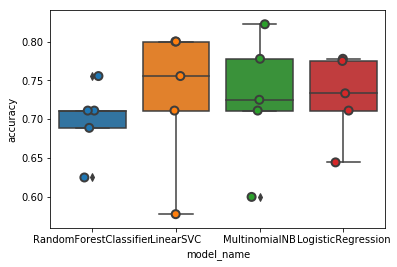

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()